***Install and import required libraries***

In [ ]:
!pip install torchinfo

In [ ]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from torchinfo import summary
import seaborn as sns
from imblearn.over_sampling import SMOTE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PLEASE EITHER IGNORE THIS CELL OR CHANGE THE LINE BELOW TO MATCH YOUR GOOGLE DRIVE DATASET PATH
# Copy from google drive into the project directory
!cp -r /content/drive/MyDrive/Deep\ Learning\ Project/dataset .

***Load UCI Occupancy Detection Dataset***

In [ ]:
# Load the datasets
data_training = pd.read_csv('./dataset/datatraining.txt', sep=",")
data_check = pd.read_csv('./dataset/datatraining.txt', sep=",")
data_test1 = pd.read_csv('./dataset/datatest.txt', sep=",")
data_test2 = pd.read_csv('./dataset/datatest2.txt', sep=",")

In [ ]:
# Check data training head
data_check.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [ ]:
print('Training data shape:', data_check.shape)
print('\nChecking for missing values:')
print(data_check.isnull().sum())
print('\nChecking data type of each feature:\n')
print(data_check.dtypes)

Training data shape: (8143, 7)

Checking for missing values:
date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

Checking data type of each feature:

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object


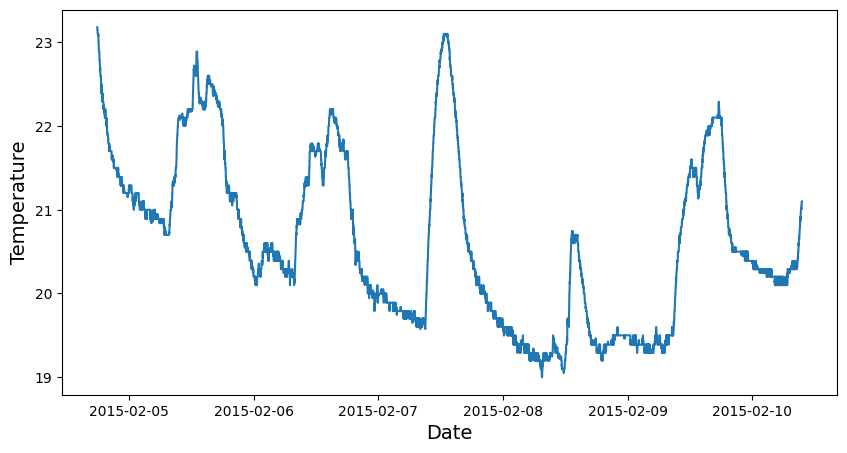

In [ ]:
# Lineplot for temperature changes for time
data_check['date'] = pd.to_datetime(data_check['date'])
plt.figure(figsize=(10, 5))
sns.lineplot(x='date', y='Temperature', data=data_check)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature', fontsize=14)
plt.show()

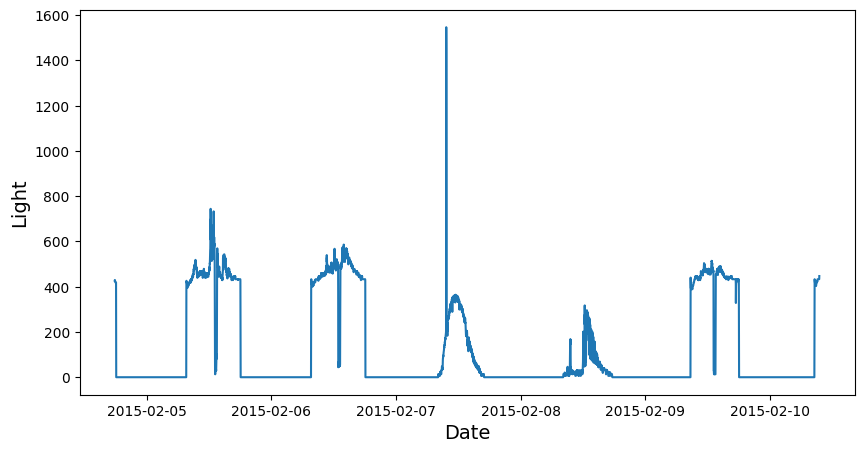

In [ ]:
# Lineplot for light changes for time
plt.figure(figsize=(10,5))
sns.lineplot(x='date',y='Light',data=data_check)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Light', fontsize=14)
plt.show()

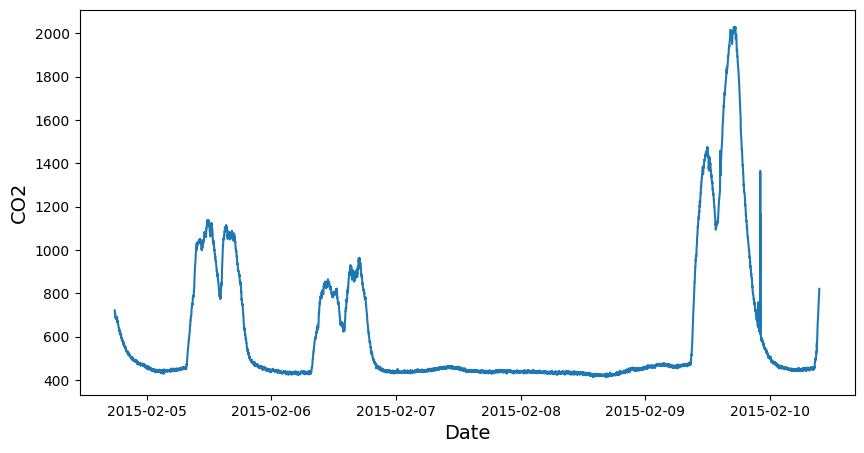

In [ ]:
# Lineplot for co2 changes for time
plt.figure(figsize=(10,5))
sns.lineplot(x='date',y='CO2',data=data_check)
plt.xlabel('Date', fontsize=14)
plt.ylabel('CO2', fontsize=14)
plt.show()

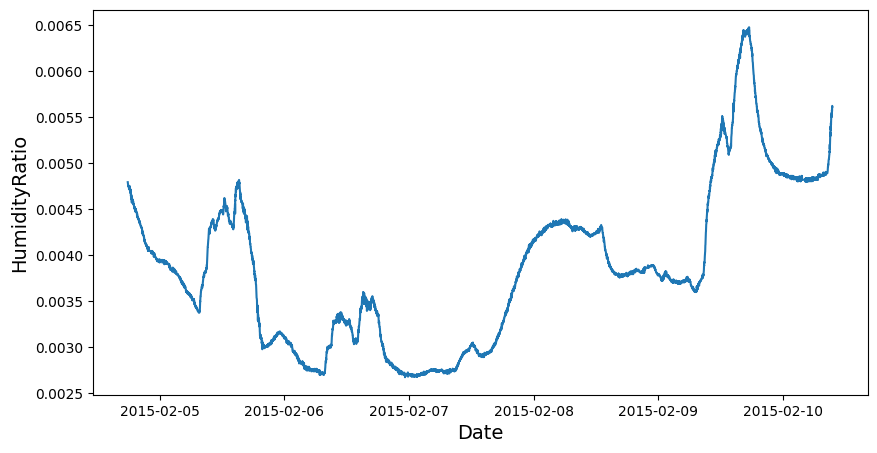

In [ ]:
# Lineplot for humidity ratio changes for time
plt.figure(figsize=(10,5))
sns.lineplot(x='date',y='HumidityRatio',data=data_check)
plt.xlabel('Date', fontsize=14)
plt.ylabel('HumidityRatio', fontsize=14)
plt.show()

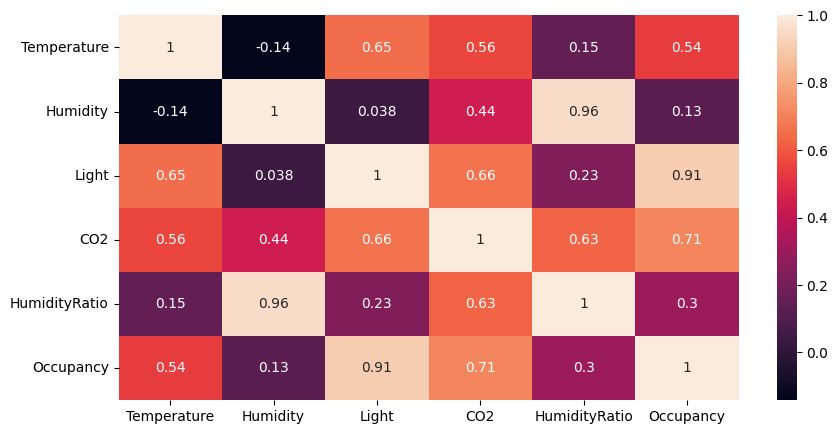

In [ ]:
# The correlation heatmap
data_check.reset_index(drop=True, inplace=True)
plt.figure(figsize=(10,5))
sns.heatmap(data_check.drop(['date'],axis=1).corr(),annot=True)
plt.show()

<Axes: title={'center': 'Features Box Plot'}>

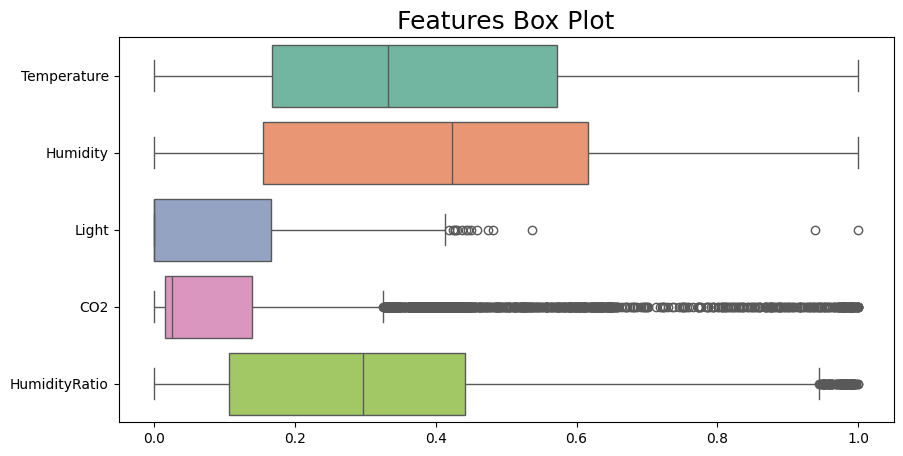

In [ ]:
scaler = MinMaxScaler()
columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
scaler.fit(np.array(data_check[columns]))
data_check[columns] = scaler.transform(np.array(data_check[columns]))
plt.figure(figsize=(10,5))
plt.title('Features Box Plot', fontdict={'fontsize':18})
sns.boxplot(data=data_check.drop(['Occupancy'],axis=1), orient="h", palette="Set2")

/home/hkj23/miniconda3/envs/to/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hkj23/miniconda3/envs/to/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hkj23/miniconda3/envs/to/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: title={'center': 'Label Distribution'}, xlabel='Occupancy', ylabel='count'>

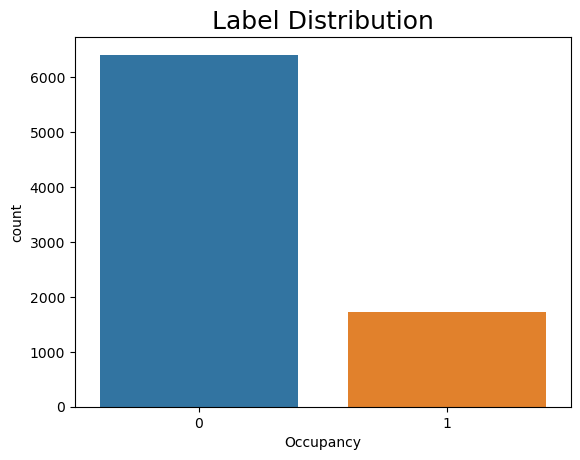

In [ ]:
plt.title("Label Distribution", fontdict={'fontsize':18})
sns.countplot(x="Occupancy", data=data_training)

In [ ]:
# Preprocess the training data
features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
X_og = data_training[features].values
y_og = data_training['Occupancy'].values

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_og, y_og)

# Convert the resampled data back to a DataFrame for further use
data_resampled = pd.DataFrame(X_resampled, columns=features)
data_resampled['Occupancy'] = y_resampled

/home/hkj23/miniconda3/envs/to/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hkj23/miniconda3/envs/to/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/hkj23/miniconda3/envs/to/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: title={'center': 'Label Distribution after oversampling'}, xlabel='Occupancy', ylabel='count'>

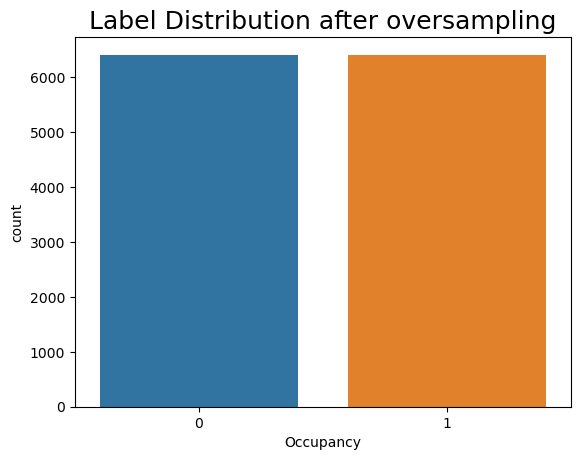

In [ ]:
plt.title("Label Distribution after oversampling", fontdict={'fontsize':18})
sns.countplot(x="Occupancy", data=data_resampled)

In [ ]:
# Now use X_resampled and y_resampled for training your models
X = data_resampled[features].values
y = data_resampled['Occupancy'].values
X_test1 = data_test1[features].values
y_test1 = data_test1['Occupancy'].values
X_test2 = data_test2[features].values
y_test2 = data_test2['Occupancy'].values

In [ ]:
# Normalize the resampled features
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test1 = scaler.transform(X_test1)
X_test2 = scaler.transform(X_test2)

# Split the resampled training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor1 = torch.tensor(X_test1, dtype=torch.float32)
y_test_tensor1 = torch.tensor(y_test1, dtype=torch.float32).view(-1, 1)
X_test_tensor2 = torch.tensor(X_test2, dtype=torch.float32)
y_test_tensor2 = torch.tensor(y_test2, dtype=torch.float32).view(-1, 1)

# Create DataLoader for training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset1 = TensorDataset(X_test_tensor1, y_test_tensor1)
test_loader1 = DataLoader(test_dataset1, batch_size=64, shuffle=False)
test_dataset2 = TensorDataset(X_test_tensor2, y_test_tensor2)
test_loader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False)

In [ ]:
# Function to train the model and validate
def train_and_validate_model(model, criterion, optimizer,train_loader, val_loader, num_epochs, patience_limit, device):
    model.to(device)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    best_val_loss = np.inf

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        training_accuracies.append(train_accuracy)
        train_loss = train_loss / len(train_loader.dataset)
        training_losses.append(train_loss)

        # Validation loss
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (val_predicted == labels).sum().item()

        # Calculate average losses
        val_accuracy = val_correct / val_total
        validation_accuracies.append(val_accuracy)
        val_loss = val_loss / len(val_loader.dataset)
        validation_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs} \tTraining Loss: {train_loss:.4f} \tTraining Accuracy: {train_accuracy:.4f} \tValidation Loss: {val_loss:.4f} \tValidation Accuracy: {val_accuracy:.4f}')
        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience > patience_limit:
                print(f'Stopping early at epoch {epoch+1}')
                break
    return training_losses, training_accuracies, validation_losses, validation_accuracies

In [ ]:
# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    model.to(device)

    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move inputs and labels to the correct device
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float().cpu()

            # Extend the lists for true labels and predictions
            y_true.extend(labels.view(-1).cpu().numpy())
            y_pred.extend(predicted.view(-1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, conf_matrix

In [ ]:
# Function to plot the training process
def plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, label='Training Loss', color='tab:blue')
    plt.plot(epochs, validation_losses, label='Validation Loss', color='tab:orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracies, label='Training Accuracy', color='tab:blue')
    plt.plot(epochs, validation_accuracies, label='Validation Accuracy', color='tab:orange')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

***MODEL 1: RANDOM FOREST CLASSIFIER***

In [ ]:
# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_val = rf_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
precision_val = precision_score(y_val, y_pred_val)
recall_val = recall_score(y_val, y_pred_val)
f1_val = f1_score(y_val, y_pred_val)
conf_matrix_val = confusion_matrix(y_val, y_pred_val)

print(f'Accuracy on validation set: {accuracy_val}')
print(f'Precision on validation set: {precision_val}')
print(f'Recall on validation set: {recall_val}')
print(f'F1 Score on validation set: {f1_val}')
print(f'Confusion Matrix on validation set:\n{conf_matrix_val}')

Accuracy on validation set: 0.9968823070927514
Precision on validation set: 0.995260663507109
Recall on validation set: 0.9984152139461173
F1 Score on validation set: 0.9968354430379747
Confusion Matrix on validation set:
[[1298    6]
 [   2 1260]]


In [ ]:
# Evaluate the model on the first test set
y_pred_test1 = rf_model.predict(X_test1)
accuracy_test1 = accuracy_score(y_test1, y_pred_test1)
precision_test1 = precision_score(y_test1, y_pred_test1)
recall_test1 = recall_score(y_test1, y_pred_test1)
f1_test1 = f1_score(y_test1, y_pred_test1)
conf_matrix_test1 = confusion_matrix(y_test1, y_pred_test1)

print(f'Accuracy on test set 1: {accuracy_test1}')
print(f'Precision on test set 1: {precision_test1}')
print(f'Recall on test set 1: {recall_test1}')
print(f'F1 Score on test set 1: {f1_test1}')
print(f'\nConfusion Matrix on test set 1:\n{conf_matrix_test1}')

Accuracy on test set 1: 0.9632270168855535
Precision on test set 1: 0.9414141414141414
Recall on test set 1: 0.9588477366255144
F1 Score on test set 1: 0.9500509683995924

Confusion Matrix on test set 1:
[[1635   58]
 [  40  932]]


In [ ]:
# Evaluate the model on the second test set
y_pred_test2 = rf_model.predict(X_test2)
accuracy_test2 = accuracy_score(y_test2, y_pred_test2)
precision_test2 = precision_score(y_test2, y_pred_test2)
recall_test2 = recall_score(y_test2, y_pred_test2)
f1_test2 = f1_score(y_test2, y_pred_test2)
conf_matrix_test2 = confusion_matrix(y_test2, y_pred_test2)

print(f'Accuracy on test set 2: {accuracy_test2}')
print(f'Precision on test set 2: {precision_test2}')
print(f'Recall on test set 2: {recall_test2}')
print(f'F1 Score on test set 2: {f1_test2}')
print(f'\nConfusion Matrix on test set 2:\n{conf_matrix_test2}')

Accuracy on test set 2: 0.9671862182116489
Precision on test set 2: 0.8753799392097265
Recall on test set 2: 0.9838945827232797
F1 Score on test set 2: 0.926470588235294

Confusion Matrix on test set 2:
[[7416  287]
 [  33 2016]]


***MODEL 2: MULTILAYER PERCEPTRON (MLP)***

In [ ]:
#Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(5, 10)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # Dropout layer after the first ReLU
        self.fc2 = nn.Linear(10, 10)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # Dropout layer after the second ReLU
        self.fc3 = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [ ]:
mlpsum = MLP()
summary(mlpsum, input_size=(5,))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1]                       --
├─Linear: 1-1                            [10]                      60
├─ReLU: 1-2                              [10]                      --
├─Dropout: 1-3                           [10]                      --
├─Linear: 1-4                            [10]                      110
├─ReLU: 1-5                              [10]                      --
├─Dropout: 1-6                           [10]                      --
├─Linear: 1-7                            [1]                       11
├─Sigmoid: 1-8                           [1]                       --
Total params: 181
Trainable params: 181
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
# Define loss function and optimizer
modelmlp = MLP()
criterion = nn.BCELoss()
optimizer = optim.Adam(modelmlp.parameters(), lr=0.001)
num_epochs = 100
patience_limit = 10
training_losses, training_accuracies, validation_losses, validation_accuracies = train_and_validate_model(modelmlp, criterion, optimizer,train_loader, val_loader, num_epochs, patience_limit, device)

Epoch 1/100 	Training Loss: 0.5856 	Training Accuracy: 0.7489 	Validation Loss: 0.3831 	Validation Accuracy: 0.9260
Epoch 2/100 	Training Loss: 0.3369 	Training Accuracy: 0.8843 	Validation Loss: 0.1457 	Validation Accuracy: 0.9571
Epoch 3/100 	Training Loss: 0.2302 	Training Accuracy: 0.9148 	Validation Loss: 0.0841 	Validation Accuracy: 0.9758
Epoch 4/100 	Training Loss: 0.1700 	Training Accuracy: 0.9369 	Validation Loss: 0.0581 	Validation Accuracy: 0.9867
Epoch 5/100 	Training Loss: 0.1469 	Training Accuracy: 0.9514 	Validation Loss: 0.0479 	Validation Accuracy: 0.9922
Epoch 6/100 	Training Loss: 0.1416 	Training Accuracy: 0.9495 	Validation Loss: 0.0454 	Validation Accuracy: 0.9910
Epoch 7/100 	Training Loss: 0.1242 	Training Accuracy: 0.9556 	Validation Loss: 0.0446 	Validation Accuracy: 0.9910
Epoch 8/100 	Training Loss: 0.1319 	Training Accuracy: 0.9594 	Validation Loss: 0.0445 	Validation Accuracy: 0.9910
Epoch 9/100 	Training Loss: 0.1240 	Training Accuracy: 0.9591 	Validatio

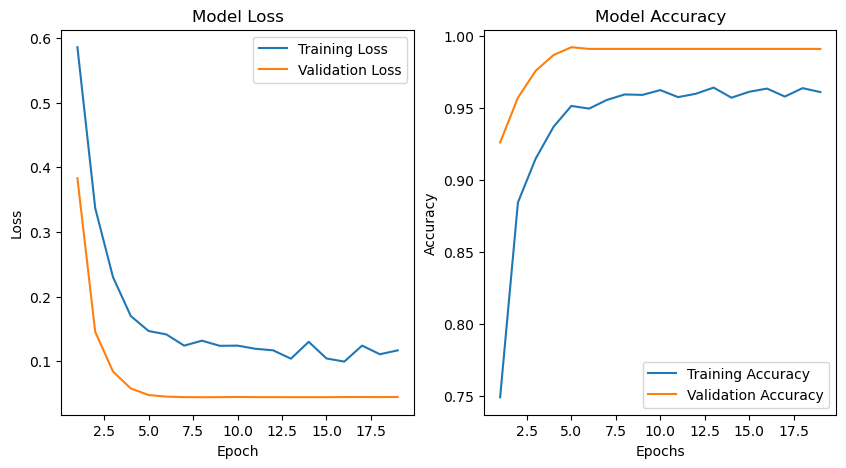

In [ ]:
# Call the plot function with the metrics collected during training
plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies, len(training_losses))

In [ ]:
# Evaluate the model on the first test set
accuracy, precision, recall, f1, conf_matrix = evaluate_model(modelmlp, test_loader1, device)
print(f'Accuracy on test set 1: {accuracy}')
print(f'Precision on test set 1: {precision}')
print(f'Recall on test set 1: {recall}')
print(f'F1 Score on test set 1: {f1}')
print(f'\nConfusion Matrix on test set 1:\n{conf_matrix}')

Accuracy on test set 1: 0.9786116322701689
Precision on test set 1: 0.9463414634146341
Recall on test set 1: 0.9979423868312757
F1 Score on test set 1: 0.971457185778668

Confusion Matrix on test set 1:
[[1638   55]
 [   2  970]]


In [ ]:
# Evaluate the model on the second test set
accuracy, precision, recall, f1, conf_matrix = evaluate_model(modelmlp, test_loader2, device)
print(f'Accuracy on test set 2: {accuracy}')
print(f'Precision on test set 2: {precision}')
print(f'Recall on test set 2: {recall}')
print(f'F1 Score on test set 2: {f1}')
print(f'\nConfusion Matrix on test set 2:\n{conf_matrix}')

Accuracy on test set 2: 0.9914889253486464
Precision on test set 2: 0.9654356060606061
Recall on test set 2: 0.995119570522206
F1 Score on test set 2: 0.9800528719057918

Confusion Matrix on test set 2:
[[7630   73]
 [  10 2039]]


***MODEL 3: CONVOLUTIONAL NEURAL NETWORK (CNN)***

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, num_filters, kernel_size, hidden_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv1d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=kernel_size, padding=kernel_size//2)
        self.max_pool = nn.MaxPool1d(kernel_size=2)

        # Calculate the output size after convolutional layers
        conv_output_size = self.calculate_conv_output_size(num_filters*2)

        self.fc1 = nn.Linear(conv_output_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

    def calculate_conv_output_size(self, num_filters):
        # Calculate the output size after convolutional layers and max pooling
        output_size = (self.input_size - self.conv1.kernel_size[0] + 2 * self.conv1.padding[0]) // 1 + 1
        output_size = (output_size - self.conv2.kernel_size[0] + 2 * self.conv2.padding[0]) // 2
        output_size = output_size * num_filters
        return output_size

In [ ]:
cnnsum = CNN(input_size=5, num_filters=32, kernel_size=3, hidden_size=64, output_size=1)
summary(cnnsum, input_size=(1,5))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 1]                    --
├─Conv1d: 1-1                            [1, 32, 5]                128
├─Conv1d: 1-2                            [1, 64, 5]                6,208
├─MaxPool1d: 1-3                         [1, 64, 2]                --
├─Dropout: 1-4                           [1, 128]                  --
├─Linear: 1-5                            [1, 64]                   8,256
├─Dropout: 1-6                           [1, 64]                   --
├─Linear: 1-7                            [1, 1]                    65
Total params: 14,657
Trainable params: 14,657
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.06

In [ ]:
# Define loss function and optimizer
modelcnn = CNN(input_size=5, num_filters=32, kernel_size=3, hidden_size=64, output_size=1)
criterion = nn.BCELoss()
optimizer = optim.Adam(modelcnn.parameters(), lr=0.001)
num_epochs = 100
patience_limit = 10
training_losses, training_accuracies, validation_losses, validation_accuracies = train_and_validate_model(modelcnn, criterion, optimizer,train_loader, val_loader, num_epochs, patience_limit, device)

Epoch 1/100 	Training Loss: 0.1277 	Training Accuracy: 0.9667 	Validation Loss: 0.0408 	Validation Accuracy: 0.9910
Epoch 2/100 	Training Loss: 0.0568 	Training Accuracy: 0.9925 	Validation Loss: 0.0387 	Validation Accuracy: 0.9910
Epoch 3/100 	Training Loss: 0.0536 	Training Accuracy: 0.9923 	Validation Loss: 0.0361 	Validation Accuracy: 0.9910
Epoch 4/100 	Training Loss: 0.0377 	Training Accuracy: 0.9926 	Validation Loss: 0.0330 	Validation Accuracy: 0.9918
Epoch 5/100 	Training Loss: 0.0347 	Training Accuracy: 0.9924 	Validation Loss: 0.0312 	Validation Accuracy: 0.9918
Epoch 6/100 	Training Loss: 0.0339 	Training Accuracy: 0.9921 	Validation Loss: 0.0287 	Validation Accuracy: 0.9918
Epoch 7/100 	Training Loss: 0.0298 	Training Accuracy: 0.9924 	Validation Loss: 0.0257 	Validation Accuracy: 0.9922
Epoch 8/100 	Training Loss: 0.0275 	Training Accuracy: 0.9928 	Validation Loss: 0.0260 	Validation Accuracy: 0.9918
Epoch 9/100 	Training Loss: 0.0277 	Training Accuracy: 0.9929 	Validatio

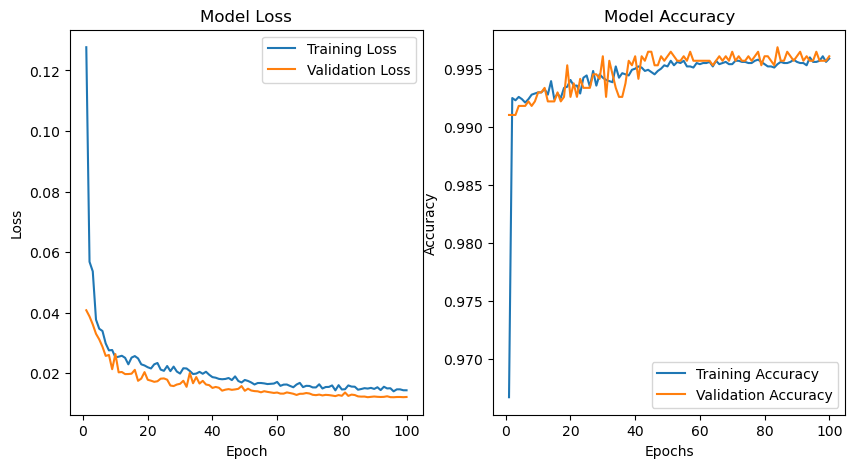

In [ ]:
# Call the plot function with the metrics collected during training
plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies, len(training_losses))

In [ ]:
# Evaluate the model on the first test set
accuracy, precision, recall, f1, conf_matrix = evaluate_model(modelcnn, test_loader1, device)
print(f'Accuracy on test set 1: {accuracy}')
print(f'Precision on test set 1: {precision}')
print(f'Recall on test set 1: {recall}')
print(f'F1 Score on test set 1: {f1}')
print(f'\nConfusion Matrix on test set 1:\n{conf_matrix}')

Accuracy on test set 1: 0.9275797373358349
Precision on test set 1: 0.9219934994582882
Recall on test set 1: 0.8755144032921811
F1 Score on test set 1: 0.8981530343007916

Confusion Matrix on test set 1:
[[1621   72]
 [ 121  851]]


In [ ]:
# Evaluate the model on the second test set
accuracy, precision, recall, f1, conf_matrix = evaluate_model(modelcnn, test_loader2, device)
print(f'Accuracy on test set 2: {accuracy}')
print(f'Precision on test set 2: {precision}')
print(f'Recall on test set 2: {recall}')
print(f'F1 Score on test set 2: {f1}')
print(f'\nConfusion Matrix on test set 2:\n{conf_matrix}')

Accuracy on test set 2: 0.9400123051681706
Precision on test set 2: 0.8671013039117352
Recall on test set 2: 0.8438262567105905
F1 Score on test set 2: 0.8553054662379421

Confusion Matrix on test set 2:
[[7438  265]
 [ 320 1729]]


***MODEL 4: LONG SHORT-TERM MEMORY NETWORK (LSTM)***

In [ ]:
# Reshape the data for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], 1, X.shape[1])
X_test1 = X_test1.reshape(X_test1.shape[0], 1, X_test1.shape[1])
X_test2 = X_test2.reshape(X_test2.shape[0], 1, X_test2.shape[1])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor1 = torch.tensor(X_test1, dtype=torch.float32)
y_test_tensor1 = torch.tensor(y_test1, dtype=torch.float32).view(-1, 1)
X_test_tensor2 = torch.tensor(X_test2, dtype=torch.float32)
y_test_tensor2 = torch.tensor(y_test2, dtype=torch.float32).view(-1, 1)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataset1 = TensorDataset(X_test_tensor1, y_test_tensor1)
test_loader1 = DataLoader(test_dataset1, batch_size=64, shuffle=False)
test_dataset2 = TensorDataset(X_test_tensor2, y_test_tensor2)
test_loader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.5)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden and cell states
        device = x.device

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        output = torch.sigmoid(out)
        return output

In [ ]:
def model_summary(model):
    print("Model Summary:")
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params += param
        print(f"{name}.shape = {parameter.shape} -> {param} parameters")
    print(f"Total Parameters: {total_params}")

lstmsum = LSTM(5, 32, 2, 1)
model_summary(lstmsum)

Model Summary:
lstm.weight_ih_l0.shape = torch.Size([128, 5]) -> 640 parameters
lstm.weight_hh_l0.shape = torch.Size([128, 32]) -> 4096 parameters
lstm.bias_ih_l0.shape = torch.Size([128]) -> 128 parameters
lstm.bias_hh_l0.shape = torch.Size([128]) -> 128 parameters
lstm.weight_ih_l1.shape = torch.Size([128, 32]) -> 4096 parameters
lstm.weight_hh_l1.shape = torch.Size([128, 32]) -> 4096 parameters
lstm.bias_ih_l1.shape = torch.Size([128]) -> 128 parameters
lstm.bias_hh_l1.shape = torch.Size([128]) -> 128 parameters
linear.weight.shape = torch.Size([1, 32]) -> 32 parameters
linear.bias.shape = torch.Size([1]) -> 1 parameters
Total Parameters: 13473


In [ ]:
# Parameters and instantiation
input_dim = 5   # number of input features
hidden_dim = 32 # LSTM hidden dimensions
num_layers = 2  # number of LSTM layers
output_dim = 1  # binary output
modellstm = LSTM(input_dim, hidden_dim, num_layers, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(modellstm.parameters(), lr=0.001)
num_epochs = 100
patience_limit = 10
training_losses, training_accuracies, validation_losses, validation_accuracies = train_and_validate_model(modellstm, criterion, optimizer,train_loader, val_loader, num_epochs, patience_limit, device)

Epoch 1/100 	Training Loss: 0.4637 	Training Accuracy: 0.8362 	Validation Loss: 0.1569 	Validation Accuracy: 0.9552
Epoch 2/100 	Training Loss: 0.0931 	Training Accuracy: 0.9748 	Validation Loss: 0.0502 	Validation Accuracy: 0.9918
Epoch 3/100 	Training Loss: 0.0505 	Training Accuracy: 0.9906 	Validation Loss: 0.0424 	Validation Accuracy: 0.9914
Epoch 4/100 	Training Loss: 0.0435 	Training Accuracy: 0.9925 	Validation Loss: 0.0417 	Validation Accuracy: 0.9910
Epoch 5/100 	Training Loss: 0.0414 	Training Accuracy: 0.9925 	Validation Loss: 0.0412 	Validation Accuracy: 0.9910
Epoch 6/100 	Training Loss: 0.0401 	Training Accuracy: 0.9923 	Validation Loss: 0.0409 	Validation Accuracy: 0.9910
Epoch 7/100 	Training Loss: 0.0391 	Training Accuracy: 0.9925 	Validation Loss: 0.0407 	Validation Accuracy: 0.9910
Epoch 8/100 	Training Loss: 0.0376 	Training Accuracy: 0.9923 	Validation Loss: 0.0397 	Validation Accuracy: 0.9910
Epoch 9/100 	Training Loss: 0.0376 	Training Accuracy: 0.9923 	Validatio

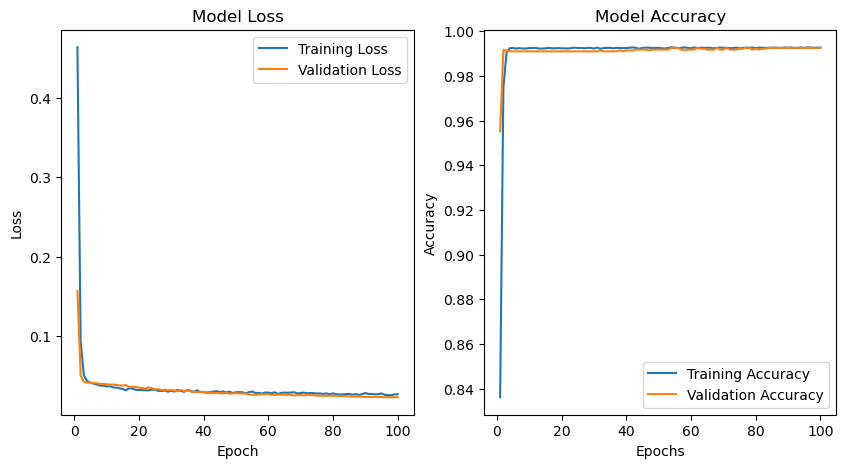

In [ ]:
# Call the plot function with the metrics collected during training
plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies, len(training_losses))

In [ ]:
# Evaluate the model on the first test set
accuracy, precision, recall, f1, conf_matrix = evaluate_model(modellstm, test_loader1, device)
print(f'Accuracy on test set 1: {accuracy}')
print(f'Precision on test set 1: {precision}')
print(f'Recall on test set 1: {recall}')
print(f'F1 Score on test set 1: {f1}')
print(f'\nConfusion Matrix on test set 1:\n{conf_matrix}')

Accuracy on test set 1: 0.976360225140713
Precision on test set 1: 0.9408341416100873
Recall on test set 1: 0.9979423868312757
F1 Score on test set 1: 0.9685471792311533

Confusion Matrix on test set 1:
[[1632   61]
 [   2  970]]


In [ ]:
# Evaluate the model on the second test set
accuracy, precision, recall, f1, conf_matrix = evaluate_model(modellstm, test_loader2\
                                                              , device)
print(f'Accuracy on test set 2: {accuracy}')
print(f'Precision on test set 2: {precision}')
print(f'Recall on test set 2: {recall}')
print(f'F1 Score on test set 2: {f1}')
print(f'\nConfusion Matrix on test set 2:\n{conf_matrix}')

Accuracy on test set 2: 0.954163248564397
Precision on test set 2: 0.8227236099919419
Recall on test set 2: 0.9965836993655441
F1 Score on test set 2: 0.9013462811741337

Confusion Matrix on test set 2:
[[7263  440]
 [   7 2042]]


***TRANSFORMER***

In [ ]:
#Define Transformer model
class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim):
        super(Transformer, self).__init__()
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          dim_feedforward=dim_feedforward)
        self.fc_in = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src):
        src = self.fc_in(src)  # Map input to the expected dimension for the transformer
        src = self.pos_encoder(src)
        output = self.transformer(src, src)
        output = self.fc_out(output[:, -1, :])  # We only care about the last time step output
        return torch.sigmoid(output)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).to(device)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].detach()

In [ ]:
transum = Transformer(5, 512, 4, 3, 2048, 1)
model_summary(transum)

Model Summary:
transformer.encoder.layers.0.self_attn.in_proj_weight.shape = torch.Size([1536, 512]) -> 786432 parameters
transformer.encoder.layers.0.self_attn.in_proj_bias.shape = torch.Size([1536]) -> 1536 parameters
transformer.encoder.layers.0.self_attn.out_proj.weight.shape = torch.Size([512, 512]) -> 262144 parameters
transformer.encoder.layers.0.self_attn.out_proj.bias.shape = torch.Size([512]) -> 512 parameters
transformer.encoder.layers.0.linear1.weight.shape = torch.Size([2048, 512]) -> 1048576 parameters
transformer.encoder.layers.0.linear1.bias.shape = torch.Size([2048]) -> 2048 parameters
transformer.encoder.layers.0.linear2.weight.shape = torch.Size([512, 2048]) -> 1048576 parameters
transformer.encoder.layers.0.linear2.bias.shape = torch.Size([512]) -> 512 parameters
transformer.encoder.layers.0.norm1.weight.shape = torch.Size([512]) -> 512 parameters
transformer.encoder.layers.0.norm1.bias.shape = torch.Size([512]) -> 512 parameters
transformer.encoder.layers.0.norm2.w

In [ ]:
# Parameters for the Transformer
input_dim = 5
d_model = 512
nhead = 4
num_encoder_layers = 3
dim_feedforward = 2048
output_dim = 1
num_epochs = 100
patience_limit = 10
modeltrans = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(modeltrans.parameters(), lr=0.00005)
training_losses, training_accuracies, validation_losses, validation_accuracies = train_and_validate_model(modeltrans, criterion, optimizer,train_loader, val_loader, num_epochs, patience_limit, device)

Epoch 1/100 	Training Loss: 0.1529 	Training Accuracy: 0.9388 	Validation Loss: 0.0645 	Validation Accuracy: 0.9836
Epoch 2/100 	Training Loss: 0.0432 	Training Accuracy: 0.9915 	Validation Loss: 0.0447 	Validation Accuracy: 0.9910
Epoch 3/100 	Training Loss: 0.0424 	Training Accuracy: 0.9920 	Validation Loss: 0.0632 	Validation Accuracy: 0.9899
Epoch 4/100 	Training Loss: 0.0433 	Training Accuracy: 0.9918 	Validation Loss: 0.0406 	Validation Accuracy: 0.9918
Epoch 5/100 	Training Loss: 0.0391 	Training Accuracy: 0.9925 	Validation Loss: 0.0526 	Validation Accuracy: 0.9910
Epoch 6/100 	Training Loss: 0.0417 	Training Accuracy: 0.9922 	Validation Loss: 0.0460 	Validation Accuracy: 0.9910
Epoch 7/100 	Training Loss: 0.0478 	Training Accuracy: 0.9904 	Validation Loss: 0.0467 	Validation Accuracy: 0.9899
Epoch 8/100 	Training Loss: 0.0451 	Training Accuracy: 0.9912 	Validation Loss: 0.0538 	Validation Accuracy: 0.9910
Epoch 9/100 	Training Loss: 0.0495 	Training Accuracy: 0.9904 	Validatio

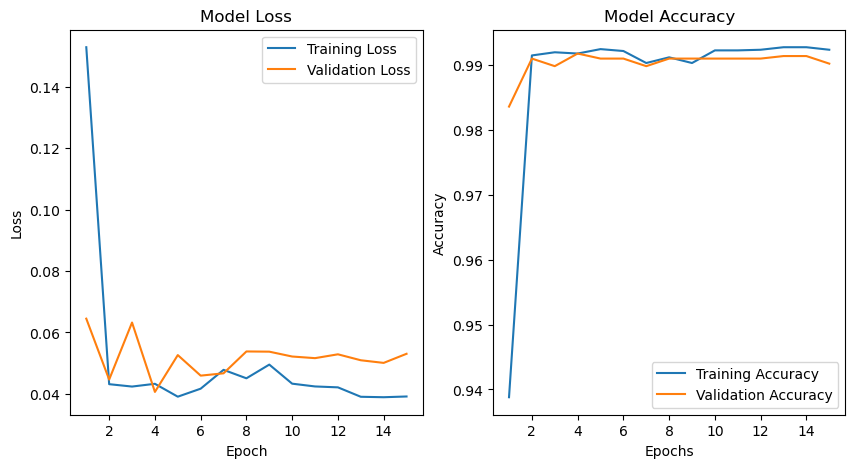

In [ ]:
# Call the plot function with the metrics collected during training
plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies, len(training_losses))

In [ ]:
# Evaluate the model on the first test set
accuracy, precision, recall, f1, conf_matrix = evaluate_model(modeltrans, test_loader1, device)
print(f'Accuracy on test set 1: {accuracy}')
print(f'Precision on test set 1: {precision}')
print(f'Recall on test set 1: {recall}')
print(f'F1 Score on test set 1: {f1}')
print(f'\nConfusion Matrix on test set 1:\n{conf_matrix}')

Accuracy on test set 1: 0.9553470919324578
Precision on test set 1: 0.9438085327783559
Recall on test set 1: 0.9331275720164609
F1 Score on test set 1: 0.9384376616658044

Confusion Matrix on test set 1:
[[1639   54]
 [  65  907]]


In [ ]:
# Evaluate the model on the second test set
accuracy, precision, recall, f1, conf_matrix = evaluate_model(modeltrans, test_loader2, device)
print(f'Accuracy on test set 2: {accuracy}')
print(f'Precision on test set 2: {precision}')
print(f'Recall on test set 2: {recall}')
print(f'F1 Score on test set 2: {f1}')
print(f'\nConfusion Matrix on test set 2:\n{conf_matrix}')

Accuracy on test set 2: 0.9702625102543068
Precision on test set 2: 0.9263208919049928
Recall on test set 2: 0.9326500732064422
F1 Score on test set 2: 0.9294747081712064

Confusion Matrix on test set 2:
[[7551  152]
 [ 138 1911]]
